# 2: Dublin-London Statistical Comparison

In [1]:
from pathlib import Path
import time
import datetime
import unittest
import numpy as np
import pandas as pd
from itertools import chain
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

sns.set(style="darkgrid", font='serif', rc={'lines.linewidth': 0.7})

data_folder = Path('data/')
chart_folder = Path('charts/')
dublin_bike_folder = Path('data/dublinbikes')

# 2.1 - Dublin and London Bike Hire comparison

In order to explore and compare the two cities for which we have bike rental data - Dublin and London, we load the previously gathered and processed daily data and attempt to combine them into a single dataset.

We will compare various aspects of the two datasets - the number of bike rentals overall, how each city's rentals reponded to the 2020 covid pandemic and lockdown, and how each city's rentals behave seasonally.

In [2]:
dublin_bikes_daily = pd.read_parquet(dublin_bike_folder/'daily_agg.parquet')
dublin_bikes_monthly = pd.read_parquet(dublin_bike_folder/'monthly_agg.parquet')
dublin_bikes_yearly = pd.read_parquet(dublin_bike_folder/'yearly_agg.parquet')
london_bikes_daily = pd.read_csv(data_folder/'london_bikes_daily.csv')
london_bikes_monthly = pd.read_csv(data_folder/'london_bikes_monthly.csv')
london_bikes_yearly = pd.read_csv(data_folder/'london_bikes_yearly.csv')

## 2.1.1 Daily rental comparison

In [3]:
dublin_bikes_daily.head()

,date,day_of_week,day_of_week_name,num_returns,num_rentals
0,2018-08-01,2,Wednesday,4508.0,4431.0
1,2018-08-02,3,Thursday,8400.0,8392.0
2,2018-08-03,4,Friday,7795.0,7798.0
3,2018-08-04,5,Saturday,5042.0,5040.0
4,2018-08-05,6,Sunday,4379.0,4384.0


In [4]:
dublin_bikes_daily['city'] = 'Dublin'
dublin_bikes_daily['date'] = pd.to_datetime(dublin_bikes_daily['date'])

In [5]:
london_bikes_daily.head() 

,day,num_hires
0,2010-07-30,6897
1,2010-07-31,5564
2,2010-08-01,4303
3,2010-08-02,6642
4,2010-08-03,7966


In [6]:
london_bikes_daily['city'] = 'London'
london_bikes_daily['day'] = pd.to_datetime(london_bikes_daily['day'])

In [7]:
daily_df = pd.concat([
    dublin_bikes_daily[['city', 'date', 'num_rentals']], 
    london_bikes_daily.rename(columns={
    'day': 'date',
    'num_hires': 'num_rentals'
    })])

daily_df.to_parquet(data_folder/'dublin_london_daily_rentals.parquet', index=False)
daily_df

,city,date,num_rentals
0,Dublin,2018-08-01,4431.0
1,Dublin,2018-08-02,8392.0
2,Dublin,2018-08-03,7798.0
3,Dublin,2018-08-04,5040.0
4,Dublin,2018-08-05,4384.0
...,...,...,...
4837,London,2023-10-27,23226.0
4838,London,2023-10-28,18970.0
4839,London,2023-10-29,12317.0
4840,London,2023-10-30,25269.0


Dublin data only goes back as far as 2018, whereas London data goes back as far as 2010, so we filter the dates down to those that are common between the two datasets.

In [18]:
common_dates = set(daily_df[daily_df['city'] == 'Dublin']['date']).intersection(set(daily_df[daily_df['city'] == 'London']['date']))
filtered_daily_df = daily_df[daily_df['date'].isin(common_dates)]
filtered_daily_df

,city,date,num_rentals
0,Dublin,2018-08-01,4431.0
1,Dublin,2018-08-02,8392.0
2,Dublin,2018-08-03,7798.0
3,Dublin,2018-08-04,5040.0
4,Dublin,2018-08-05,4384.0
...,...,...,...
4837,London,2023-10-27,23226.0
4838,London,2023-10-28,18970.0
4839,London,2023-10-29,12317.0
4840,London,2023-10-30,25269.0


Comparing the distributions of both sets of daily rentals, it can be seen that London has approximately normally distributed rentals, whereas Dublin is more log-normally distributed.

It can also be seen that the scales of the numbers of rentals are quite different, with London having many more daily rentals on average. This is expected given the population difference between the two cities.

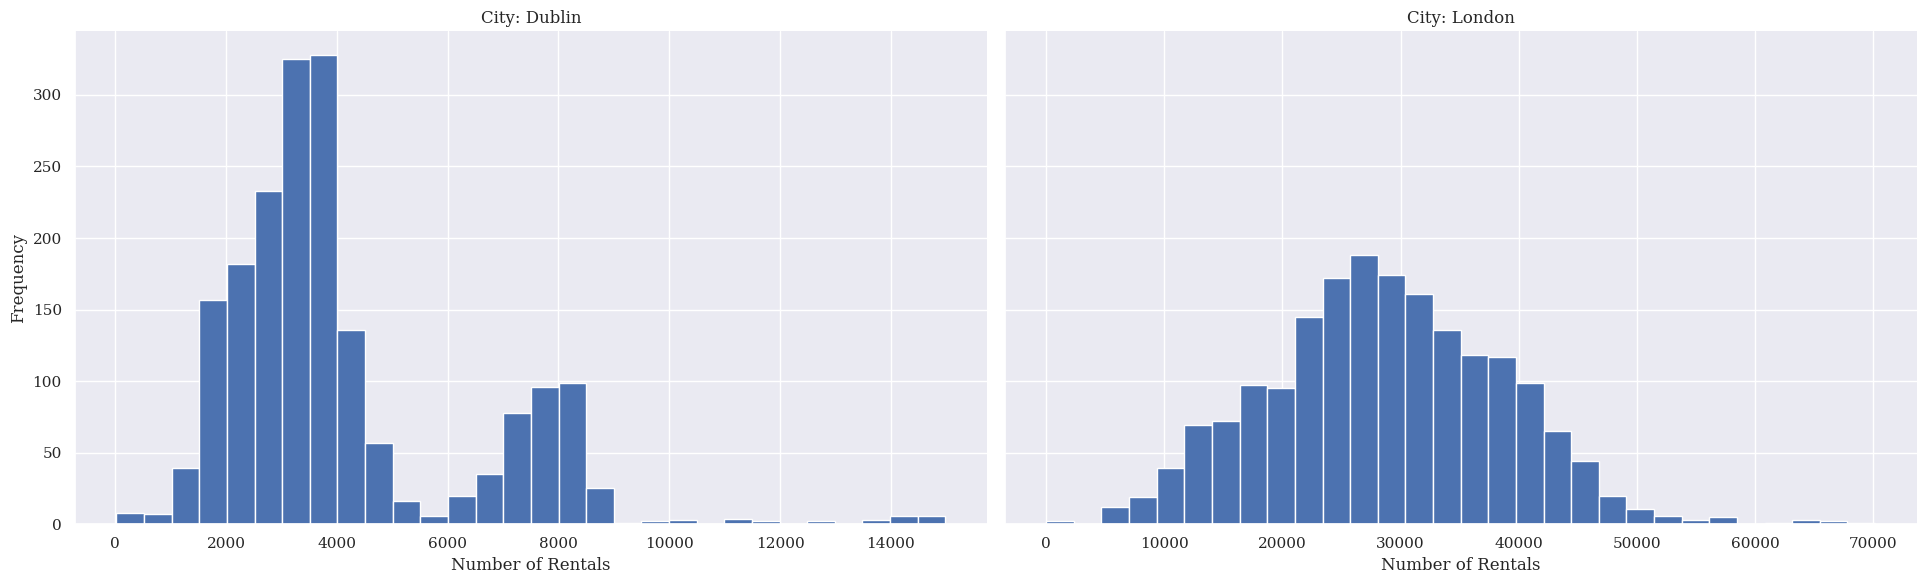

In [23]:
g = sns.FacetGrid(filtered_daily_df, 
                  col="city", 
                  height=6, 
                  aspect=1.6, 
                  sharex=False)

g.map(plt.hist, "num_rentals", bins=30)
g.set_axis_labels("Number of Rentals", "Frequency")
g.set_titles("City: {col_name}")

plt.show();

g.savefig(chart_folder / 'total_rental_comparison.png')

In [21]:
# most of the large values occur before 2021
filtered_daily_df['month'] = filtered_daily_df['date'].dt.month_name()
filtered_daily_df['year'] = filtered_daily_df['date'].dt.year
filtered_daily_df.loc[(filtered_daily_df['city'] == 'Dublin') & (filtered_daily_df['num_rentals'] > 6000)].groupby(['month', 'year']).count()

city  date  num_rentals
month     year                         
April     2019    20    20           20
August    2018    21    21           21
          2019    21    21           21
December  2018    15    15           15
          2019     6     6            6
February  2019    20    20           20
          2020    20    20           20
January   2019    22    22           22
          2020     7     7            7
July      2019    23    23           23
June      2019     5     5            5
March     2019    19    19           19
          2020     7     7            7
May       2019    22    22           22
November  2018    21    21           21
          2019    19    19           19
October   2018    22    22           22
          2019    22    22           22
          2021    30    30           30
September 2018    20    20           20
          2019    20    20           20

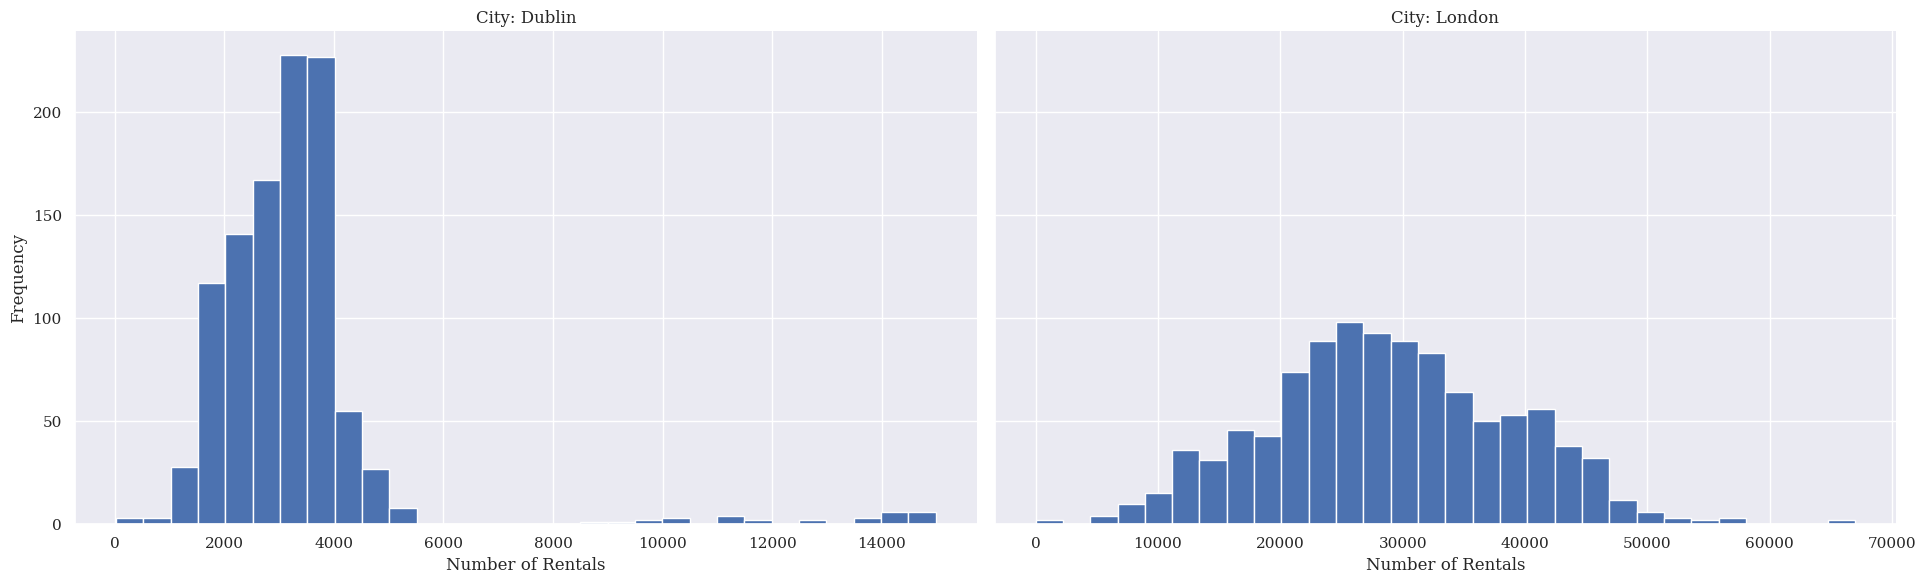

In [25]:
# these now both look normal - Dublin has some outliers
g = sns.FacetGrid(filtered_daily_df.loc[filtered_daily_df['year'] >= 2021], 
                  col="city", 
                  height=6, 
                  aspect=1.6, 
                  sharex=False)

g.map(plt.hist, "num_rentals", bins=30)
g.set_axis_labels("Number of Rentals", "Frequency")
g.set_titles("City: {col_name}")

plt.show();

g.savefig(chart_folder / 'total_rental_comparison_2021.png')

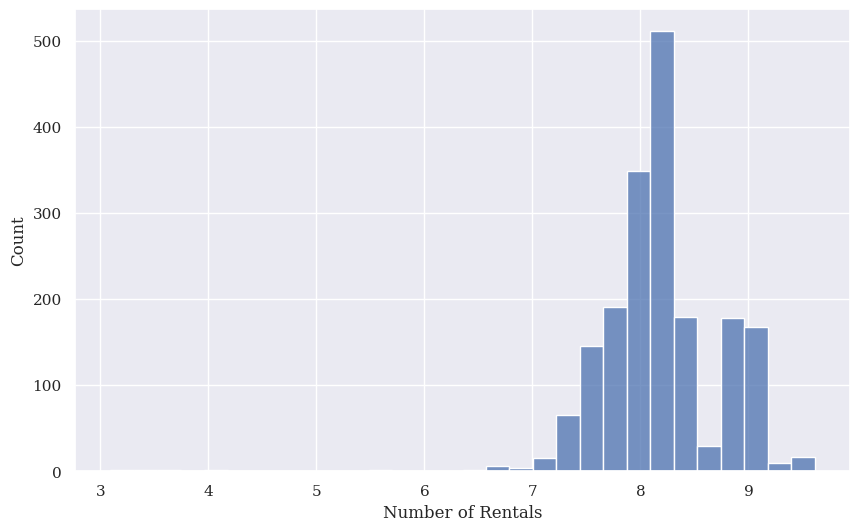

In [10]:
fig = plt.figure(figsize=(10, 6))
g = sns.histplot(np.log(filtered_daily_df.loc[filtered_daily_df['city'] == 'Dublin']['num_rentals']), bins=30, kde=False)
g.set(xlabel="Number of Rentals")

[Text(0.5, 0, 'Number of Rentals')]

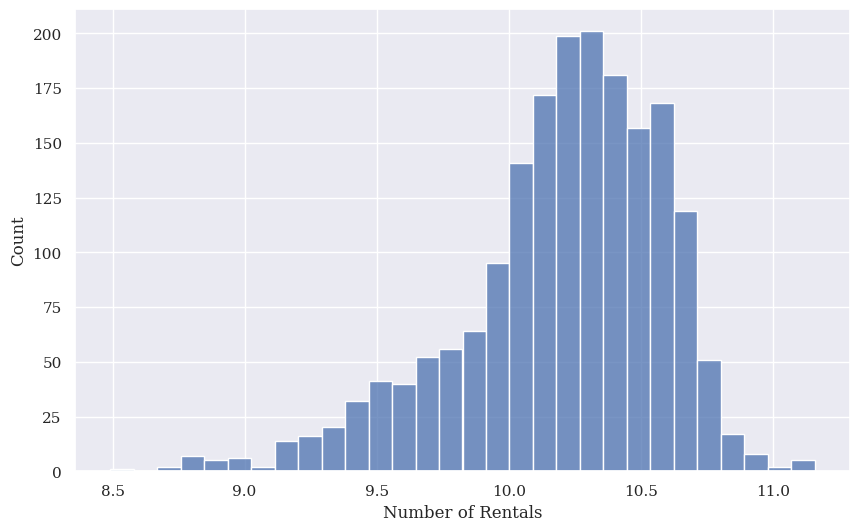

In [12]:
fig = plt.figure(figsize=(10, 6))
g = sns.histplot(np.log(filtered_daily_df.loc[filtered_daily_df['city'] == 'London']['num_rentals']), bins=30, kde=False)
g.set(xlabel="Number of Rentals")

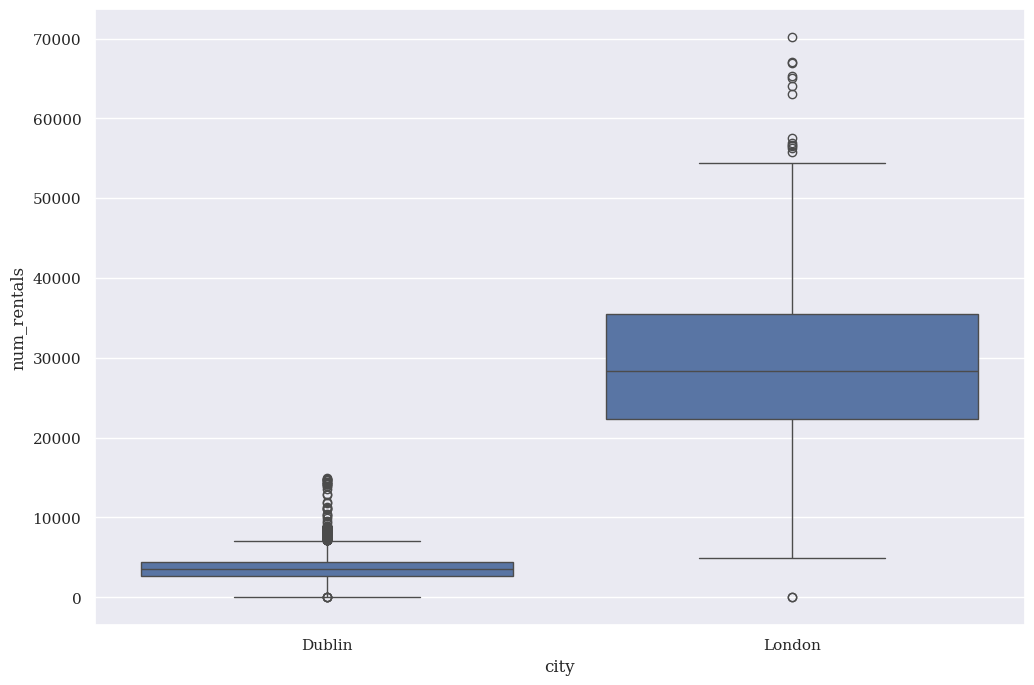

In [11]:
plt.figure(figsize=(12,8))
sns.boxplot(data=filtered_daily_df, x='city', y='num_rentals')
plt.savefig(chart_folder / 'total_rental_comparison_box.png');

We would expect the scale difference for bike rentals to be roughly in-line with the population scale differences. We can see that comparing our median daily rentals give a factor of 8.11x, whereas population estimates give a factor of 9.8x. This is a rough estimate, but it appears to be in the right range.

This will be affected by several factors. The bike networks do not cover the whole of either city, the amount of rentals will naturally be affected by how useful the network is to the populace, so the population within the network's coverage may be a more fair comparison than the total population. Also, the population estimates retrieved are for the metropolitan areas of each city, and as such overestimate the population by including commuter towns / boroughs. The Dublin estimate of 1.5m seems particularly overinflated, when Dublin city council reported a population of less that 0.5m in the city center at the last census.

In [10]:
dublin_med = np.median(filtered_daily_df.loc[filtered_daily_df['city'] == 'Dublin']['num_rentals'])
london_med = np.median(filtered_daily_df.loc[filtered_daily_df['city'] == 'London']['num_rentals'])

london_med/dublin_med

8.113698043136695

In [11]:
# https://visual.cso.ie/?body=entity/ima/cop/2022&boundary=C03789V04537&guid=2ae19629-1433-13a3-e055-000000000001B - dcc population
# https://www.citypopulation.de/en/world/agglomerations/
dublin_pop = 1510000
london_pop = 14800000
london_pop/dublin_pop

9.801324503311259

### Comparing daily rentals between cities

An independent t-test can be used to compare the mean daily bike rentals between Dublin and London - these groups are independent as the rentals occur in different cities, and as the sample size in both cases is large (1876), we can trust that the normality assumption holds ().

The null hypothesis (H0) is taken as that there is no significant difference in the mean rentals, with a threshold of alpha=0.05 by convention.

In [36]:
filtered_daily_df[filtered_daily_df['city'] == 'Dublin']['num_rentals'].shape

(1876,)

In [26]:
_, p = stats.ttest_ind(
    filtered_daily_df[filtered_daily_df['city'] == 'Dublin']['num_rentals'],
    filtered_daily_df[filtered_daily_df['city'] == 'London']['num_rentals']
)
p

0.0

For both the full dataset, and the post 2021 dataset, we see that the data fits the normality assupmption as the 
As we find a p value of < 0.05, we reject the null hypothesis and conclude that the mean daily rentals are significantly different in London than in Dublin at a 95% significance level.

## 2.1.2 Comparing 2019 & 2020 daily rentals

A Wilcoxon test can be used to compare the distributions of bike rentals before and after 2020. These can be thought of as paired samples before and after an "intervention" (in this case the pandemic).
Once again, the null hypothesis is that there is no difference and a threshold value of 0.05 is used.

In [88]:
filtered_daily_df['year'] = filtered_daily_df['date'].dt.year

# ensure we can filter down to days that are recorded both in 2019 and 2020
filtered_daily_df['month_day'] = filtered_daily_df['date'].apply(lambda x: f"{x.month}_{x.day}")

dublin_2019 = filtered_daily_df[(filtered_daily_df['city'] == 'Dublin') & (filtered_daily_df['year'] == 2019)][['month_day', 'num_rentals']]
dublin_2020 = filtered_daily_df[(filtered_daily_df['city'] == 'Dublin') & (filtered_daily_df['year'] == 2020)][['month_day', 'num_rentals']]

common_dates = set(dublin_2019['month_day']).intersection(set(dublin_2020['month_day']))
dublin_2019 = dublin_2019[dublin_2019['month_day'].isin(common_dates)]['num_rentals']
dublin_2020 = dublin_2020[dublin_2020['month_day'].isin(common_dates)]['num_rentals']

london_2019 = filtered_daily_df[(filtered_daily_df['city'] == 'London') & (filtered_daily_df['year'] == 2019)][['month_day', 'num_rentals']]
london_2020 = filtered_daily_df[(filtered_daily_df['city'] == 'London') & (filtered_daily_df['year'] == 2020)][['month_day', 'num_rentals']]

common_dates = set(london_2019['month_day']).intersection(set(london_2020['month_day']))
london_2019 = london_2019[london_2019['month_day'].isin(common_dates)]['num_rentals']
london_2020 = london_2020[london_2020['month_day'].isin(common_dates)]['num_rentals']

_, p_dublin = stats.wilcoxon(dublin_2019, dublin_2020)
_, p_london = stats.wilcoxon(london_2019, london_2020)

print(f"Dublin P-value: {p_dublin}")
print(f"London P-value: {p_london}")

Dublin P-value: 5.326783884474284e-45
London P-value: 0.6237258471872174


The daily bike rentals is found to be significantly different between 2019 and 2020 for Dublin as the p value is less than the chosen threshold. However, the null hypothesis is not rejected for London - indicating that there was no significant difference in daily bike hire between the two years. London had a less restrictive covid lockdown in 2020 than Dublin - this could explain the difference between the two cities.

We can investigate this further by looking at the daily rentals for both cities as pair of lineplots. Here, two subplots are used rather than two series in the sampe plotting window as the scales are very different between the two cities, and we are more concerned with the overall pattern.

We see a large decrease in rentals in Dublin beginning in Spring 2020 - around the beginning of covid restrictions. Whereas in London the pattern is completely different, with rentals appearing to increase on average over the same time period.

<Figure size 1000x800 with 0 Axes>

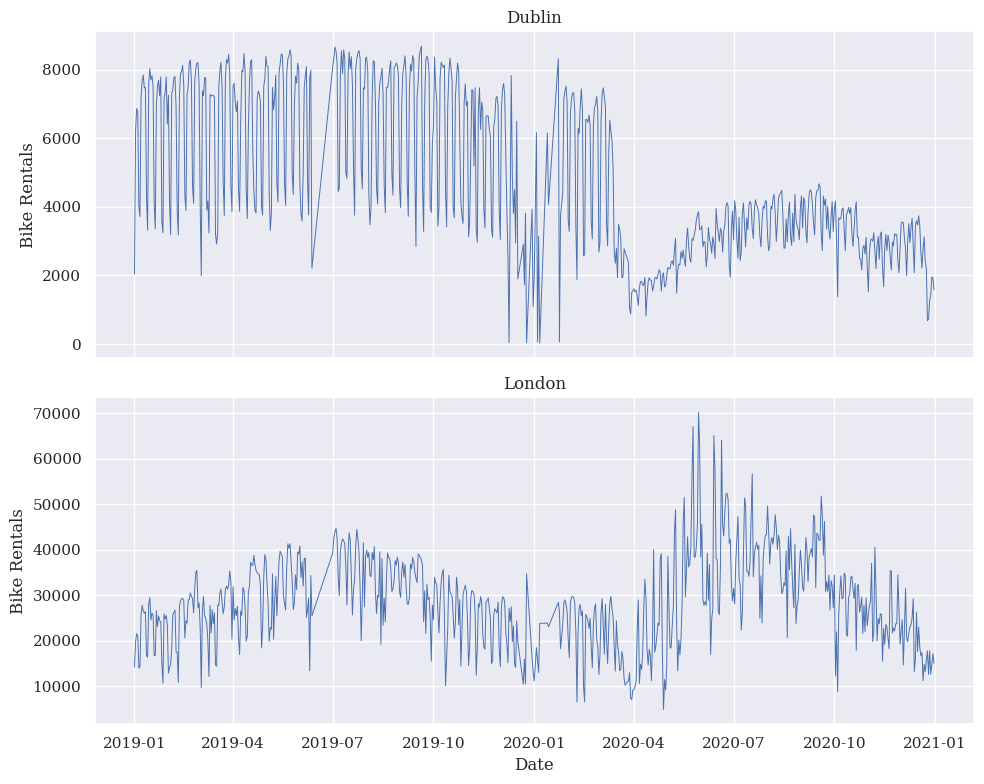

In [142]:
plt.figure(figsize=((10,8)))
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

sns.lineplot(ax=axes[0], x='date', y='num_rentals', data=filtered_daily_df[(filtered_daily_df['city'] == 'Dublin') & (filtered_daily_df['year'].between(2019, 2020))])
axes[0].set_title('Dublin')
axes[0].set_ylabel('Bike Rentals')

sns.lineplot(ax=axes[1], x='date', y='num_rentals', data=filtered_daily_df[(filtered_daily_df['city'] == 'London') & (filtered_daily_df['year'].between(2019, 2020))])
axes[1].set_title('London')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Bike Rentals')

plt.tight_layout()
plt.savefig(chart_folder / 'covid_rental_comparison.png')
plt.show();

### 2.1.3 Relationship between rentals and Month of the year

As bike rental data is a time series, it is important that we investigate possible seasonal effects. Variations in rentals due to seasonality, the month of the year in particular, could be important signals for further ML applications. In this section the relationship between bike rentals and the month across both Dublin and London is explored.

A mann-whitney U test can be carried out to check whether or not there is a significant difference between the monthly rentals across both cities. The null hypothesis for this test is that there is no difference between the distributions of the two.

Additionally, a chi-square test can be carried out to investigate the relationship between the categorical variables of month and city in order to determine whether there are differing seasonal effects between the two cities. The null hypothesis in this case is that there is no association between distributions of rentals across the months between cities.

The proportion of the total rentals for the year is analysed to control for the differences in scale between the two cities in both of these tests, and again, by convention, we choose a threshold value of 0.05. 

In [119]:
filtered_daily_df['month'] = filtered_daily_df['date'].dt.month_name()
yearly_totals = filtered_daily_df.groupby(['city', 'year'])['num_rentals'].sum().reset_index().rename(columns={'num_rentals': 'yearly_totals'})
monthly_totals = filtered_daily_df.groupby(['city', 'year', 'month'])['num_rentals'].sum().reset_index().rename(columns={'num_rentals': 'monthly_totals'})
monthly_df = monthly_totals.merge(yearly_totals, how='left', on=['city', 'year'])
monthly_df['proportion_of_year'] = monthly_df['monthly_totals']/monthly_df['yearly_totals']

In [120]:
monthly_df

,city,year,month,monthly_totals,yearly_totals,proportion_of_year
0,Dublin,2018,August,213715.0,1004363.0,0.212787
1,Dublin,2018,December,164807.0,1004363.0,0.164091
2,Dublin,2018,November,198828.0,1004363.0,0.197964
3,Dublin,2018,October,219214.0,1004363.0,0.218262
4,Dublin,2018,September,207799.0,1004363.0,0.206896
...,...,...,...,...,...,...
121,London,2023,June,884730.0,7392064.0,0.119686
122,London,2023,March,630605.0,7392064.0,0.085308
123,London,2023,May,821433.0,7392064.0,0.111124
124,London,2023,October,789807.0,7392064.0,0.106845


In [133]:
monthly_dublin = monthly_df[monthly_df['city'] == 'Dublin']
monthly_london = monthly_df[monthly_df['city'] == 'London']

In [132]:
_, p_value = stats.mannwhitneyu(monthly_dublin['proportion_of_year'], monthly_london['proportion_of_year'])
p_value

0.4642422333468422

We fail to reject the null hypothesis as the p value is greater than our threshold of 0.05. This can be interpreted that the monthly rentals (when expressed as a proportion of the rentals for the year) are distributed similarly in both Dublin and London. 

In [96]:
pivot_df = pd.pivot_table(monthly_df, index='city', columns='month', values='proportion_of_year', aggfunc='mean')
pivot_df 

month,April,August,December,February,January,July,June,March,May,November,October,September
city,,,,,,,,,,,,
Dublin,0.074089,0.113784,0.082368,0.084484,0.068283,0.094182,0.076938,0.084301,0.088111,0.103540,0.142746,0.113222
London,0.082819,0.130347,0.068844,0.066153,0.056821,0.113164,0.098587,0.076484,0.103040,0.093852,0.113290,0.123224


In [97]:
chi2_stat, p_value, dof, expected = stats.chi2_contingency(pivot_df)

p_value

0.9999999999999887

The p value is greater than the threshold of 0.05, we fail to reject the null hypothesis - indicating that the association between the city and month variables is not significantly different. In other words, there is insufficient evidence to claim that the impact of the seasons on bike rentals is different in London than in Dublin. 

Additionally, ANOVA can tell us whether there are differences in the mean rentals per month - or rather, whether monthly seasonal effects exist at all.

In [121]:
monthly_dublin = monthly_df[monthly_df['city'] == 'Dublin']
monthly_london = monthly_df[monthly_df['city'] == 'London']

_, p_value_dublin = stats.f_oneway(*[x['proportion_of_year'] for _, x in monthly_dublin.groupby('month')])
_, p_value_london = stats.f_oneway(*[x['proportion_of_year'] for _, x in monthly_london.groupby('month')])

print(f'Dublin: {p_value_dublin}')
print(f'London: {p_value_london}')

Dublin: 0.17990951337831682
London: 0.022275738235514417


We reject the null hypothesis in the case of Dublin, but not London. This indicates that there is some level of seasonal effect due to the month of the year occuring in London, but not in Dublin.

Visually, we can see that the London seasonal effect is distinct, with fewer rentals in the winter than the summer, whereas Dublin's rentals are not as easily visually separated, and have much wider spreads from month to month.

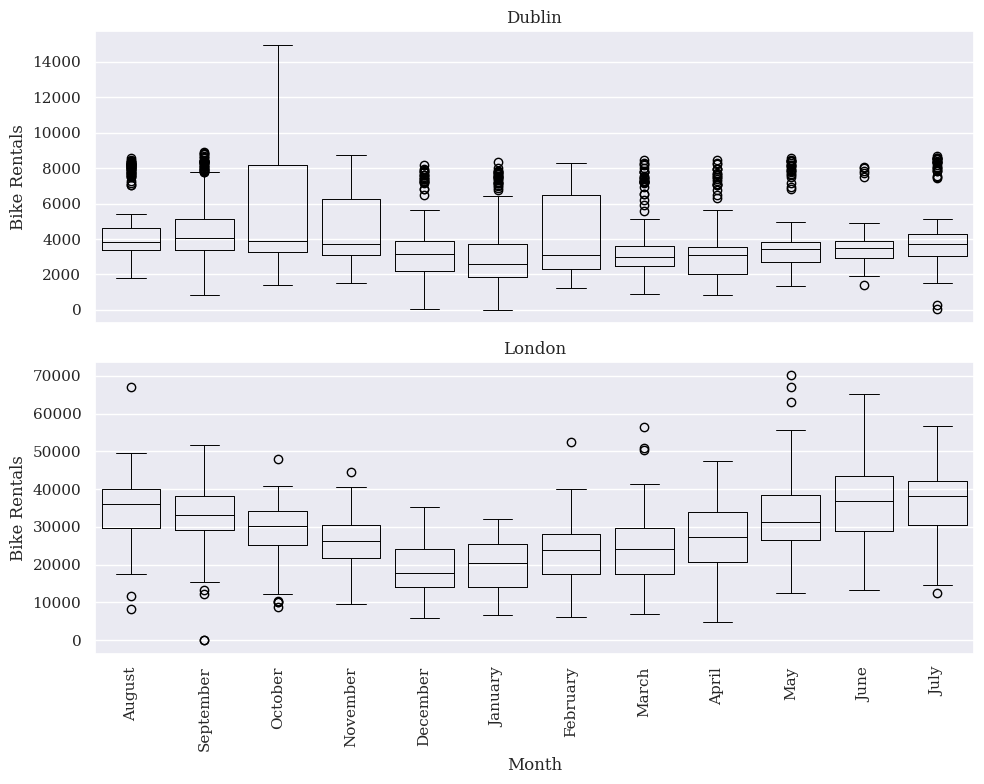

In [143]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

sns.boxplot(ax=axes[0], x='month', y='num_rentals', data=filtered_daily_df[filtered_daily_df['city'] == 'Dublin'], fill=None, color='black')
axes[0].set_title('Dublin')
axes[0].set_ylabel('Bike Rentals')

sns.boxplot(ax=axes[1], x='month', y='num_rentals', data=filtered_daily_df[filtered_daily_df['city'] == 'London'], fill=None, color='black')
axes[1].set_title('London')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Bike Rentals')
axes[1].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.savefig(chart_folder / 'city_season_comparison.png')
plt.show()

Thusfar we have learned:

- There is a significant difference between the number of rentals in Dublin and London. This may seem obvious, given the difference in scale between both cities, but it is important to be aware of this scale difference and how it affects other analyses.
- There are significant differences between years across the cities, particularly around Covid. Going forward, we should be aware of this and include year as an indicator variable in further ML analysis. Perhaps an indicator variable for pre and post lockdown would also be appropriate.
- When monthly rentals are expressed as a proportion of rentals for the year in order to mitigate the aforementioned scale issue, there is no significant differnece between the distributions of monthly rentals between London and Dublin.
- The seasonal effects are not significantly different between London and Dublin, therefore if we were performing additional machine learning on a combined dataset, a compound month/city indicator variable would be unlikely to prove useful
- Although the seasonal effects are not significantly different between the two cities, there are noticable seasonal effects in the London data that are not significant in the Dublin data.